## Install packages

In [1]:

# install.packages("StMoMo")
# install.packages("forecast")
# install.packages("demography")

also installing the dependencies 'TTR', 'curl', 'quadprog', 'quantmod', 'dotCall64', 'nnet', 'qvcalc', 'relimp', 'fracdiff', 'lmtest', 'timeDate', 'tseries', 'urca', 'spam', 'maps', 'gnm', 'forecast', 'rootSolve', 'fanplot', 'fields'



package 'TTR' successfully unpacked and MD5 sums checked
package 'curl' successfully unpacked and MD5 sums checked
package 'quadprog' successfully unpacked and MD5 sums checked
package 'quantmod' successfully unpacked and MD5 sums checked
package 'dotCall64' successfully unpacked and MD5 sums checked
package 'nnet' successfully unpacked and MD5 sums checked
package 'qvcalc' successfully unpacked and MD5 sums checked
package 'relimp' successfully unpacked and MD5 sums checked
package 'fracdiff' successfully unpacked and MD5 sums checked
package 'lmtest' successfully unpacked and MD5 sums checked
package 'timeDate' successfully unpacked and MD5 sums checked
package 'tseries' successfully unpacked and MD5 sums checked
package 'urca' successfully unpacked and MD5 sums checked
package 'spam' successfully unpacked and MD5 sums checked
package 'maps' successfully unpacked and MD5 sums checked
package 'gnm' successfully unpacked and MD5 sums checked
package 'forecast' successfully unpacked and

In [4]:
library("demography")
library("forecast")
library("demography")

Warning message:
"package 'demography' was built under R version 3.6.3"Loading required package: forecast
Warning message:
"package 'forecast' was built under R version 3.6.3"Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
This is demography 1.22 



In [6]:
thor <- read.demogdata(file="Mx_1x1.txt", popfile="Exposures_1x1.txt",
                       type="mortality", label="U.K")
names(thor)

[1] "type"   "label"  "lambda" "year"   "age"    "rate"   "pop"

In [7]:
summary(thor)

Mortality data for U.K
    Series: female male total
    Years: 1955 - 2016
    Ages:  0 - 110 


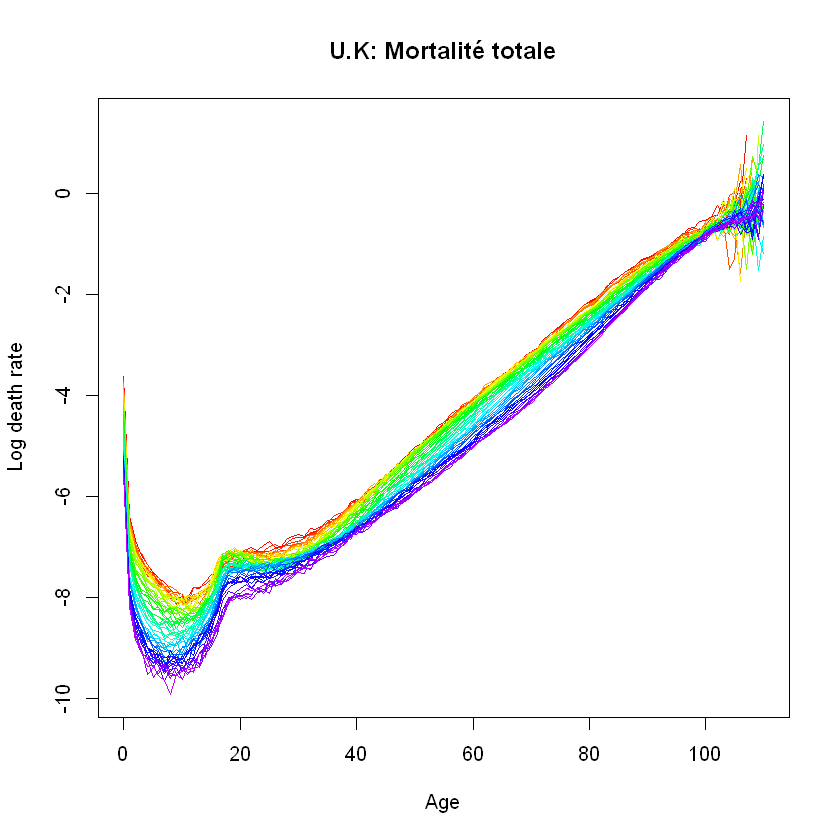

In [17]:
plot(x=thor,series=names(thor$rate)[3],
               ages=thor$age, years=thor$year,
               max.age=max(thor$age)
               ,plot.type="functions", main="U.K: Mortalité totale")